# Graph Neural Network

Author: Adam Darmanin (research and architecture) & Christian Spiteri Gauci (training)

## Tensorflow GCN Citation

```latex
@misc{StellarGraph,
  author = {CSIRO's Data61},
  title = {StellarGraph Machine Learning Library},
  year = {2018},
  publisher = {GitHub},
  journal = {GitHub Repository},
  howpublished = {\url{https://github.com/stellargraph/stellargraph}},
}
```

## Supervised graph classification Problem

Posts are graphs, and graphs are within a mental health category. We need to classify the graph.

Using a graph-based approach where nodes represent words and edges represent their directional relationships, with sentiment and other features, it can be a problem that requires a geometric deep learning solution (Adam: althouth NLP would still he the best). 
In this context, the graph captures the semantic and syntactic structure of the text within the social media post, while sentiment analysis adds another layer of understanding regarding the emotional tone of the content - e.g. someone in duress and suffering from a condition VS someone who is explaining the mental health issue.

Such a model could potentially identify patterns in the language use, the slang, the memes, that is specific to someone suffering from or is involved with a mental health condition. For instance, certain words or phrases might be more commonly used in the context of depression or anxiety: I have no hope (suicide/depression), and the relationships between these words could provide further insights. The sentiment of these words or phrases could also be indicative of the underlying mental state - sentiment is important because "I have no hope...I don't know what do do" (actual psychological duress) is different from "I have no hope beating you in chess" (a colloqial way to say things).


- paper: https://arxiv.org/abs/1902.06673
- see: https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html#Edge-features
- see: https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/

GNNS take graphs as inputs, and perform trained transformations and aggregations of features across the nodes and edges.
GNNs maintain vectors for each node - the node state, similar to a neuron.

The GNN updates the states with trainable functions: message passing, convolutions or attention. An update is
1. States are broadcas across edges.
2. Message is computed as an aggregate function.
3. Nodes pool messages using a fucntion or attention model.
4. Each node updates the state - using a NN possible.
5. Process is repeated.
6. Hetero graphs get seperate wieghts. Irregular and not possible with a normal tensor (similar to NLP) and needs a graph tensor (ragged tensor), this also store direction.
7. Trained e2e by BP to reduct loss.
8. Reading out the final GNN  state

Arch:
- Encoder for input features
- GNN for state update
- A prediction head
- Node sets - feature containers + size info, -1 being latent and ragged. All nodes in a set (id) have same features.
- lantent nodes - nodes with out features whose embeddings will be calc.
- Edge Sets (source and target), ead set also has adjancy object.
- homo graphs - edge sets on single type of node (both source and target)
- Context or Global features. The ground truth for the whole graph or sub-graph.

In training, a seed node or sub-graph is required. Graph classification, take tensor with hidden states and apply a classifier on top, this is for an inplicit readout for a sinlge node of interest, or direct readout for a feture tensor. Can aklso have a special node for structre readouts.

# Graph Schema

- see: tensorflow_gnn/proto/graph_schema.proto:GraphSchema
- see schema: ./gnn/mh_gnn.pbtxt

- Validate schema: `tfgnn_validate_graph_schema --logtostderr --graph_schema=gnn/mh_graph.pbtxt`
- Generatete mock training data: `tfgnn_generate_training_data --graph_schema=gnn/mh_graph.pbtxt --examples=gnn/mh_graph.tfrecord --file_format=tfrecord --num_examples=100`

#### Getting 6 dataframes from the graph using queries. Fix LIMIT size to change reach

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import random
import os
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
client_id = os.getenv("N4J_USER")
client_secret = os.getenv("N4J_PW")


def convert_to_list(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    return value


def fetch_mental_health_disorder_data(session):
    mental_health_disorder_dataframes = {}

    # This query was tested on Neo4j and it worked
    mental_health_disorders_query = "MATCH (m:Mental_Health_Disorder) RETURN m"

    mental_health_disorders_result = session.run(mental_health_disorders_query)

    for mental_health_disorder_record in tqdm(
        mental_health_disorders_result,
        desc="Processing Mental Health Disorders",
        unit="node",
    ):
        mental_health_disorder_node = mental_health_disorder_record["m"]

        disorder_name = mental_health_disorder_node.get("name")
        print(f"Mental Health Disorder Name: {disorder_name}")

        relationships_query = "MATCH path=(m:Mental_Health_Disorder)-[r*1..5]-(n) WHERE ID(m) = $mental_health_disorder_node_id RETURN path LIMIT 15000"  # LIMIT 1000 #Change Limit number to any number. Can remove for whole graph
        relationships_result = session.run(
            relationships_query,
            {"mental_health_disorder_node_id": mental_health_disorder_node.id},
        )

        relationships_data = []
        for rel_record in relationships_result:
            path = rel_record["path"]
            nodes = path.nodes

            for i in range(len(nodes) - 1):
                source_node = nodes[i]
                target_node = nodes[i + 1]
                relationship_type = path.relationships[i].type

                # relationships_data.append(
                #     {
                #         "source_embedding": convert_to_list(source_node.get("embedding")),
                #         "relationship": relationship_type,
                #         "target_embedding": convert_to_list(target_node.get("embedding")),
                #     }
                # )

                relationships_data.append(
                    {
                        "source_node_name": source_node.get("name"),
                        "source_embedding": convert_to_list(
                            source_node.get("embedding")
                        ),
                        "relationship": relationship_type,
                        "target_node_name": target_node.get("name"),
                        "target_embedding": convert_to_list(
                            target_node.get("embedding")
                        ),
                    }
                )

        print(f"Length of relationships_data: {len(relationships_data)}")

        df_name = f"df_{disorder_name.replace(' ', '_')}"
        mental_health_disorder_dataframes[df_name] = pd.DataFrame(relationships_data)
        print(f"Created DataFrame: {df_name}")

    return mental_health_disorder_dataframes


with GraphDatabase.driver(uri, auth=(client_id, client_secret)) as driver:
    with driver.session() as session:
        mental_health_disorder_dataframes = fetch_mental_health_disorder_data(session)

In [54]:
print(mental_health_disorder_dataframes["df_anxiety"])

      source_node_name                                   source_embedding  \
0              anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
1              anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
2               thrown  [-0.021872837096452713, -0.0012634199811145663...   
3              anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
4               thrown  [-0.021872837096452713, -0.0012634199811145663...   
...                ...                                                ...   
74930          anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
74931           thrown  [-0.021872837096452713, -0.0012634199811145663...   
74932            trash  [-0.05023549497127533, 0.028847483918070793, 0...   
74933            threw  [-0.03953901305794716, 0.07019364833831787, 0....   
74934          anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   

      relationship target_node_name  \
0             dobj           thrown 

Keeping the words as Nodes, and then creating a df with the embedding as a feature of those words to be able to feed to GCN

In [55]:
from stellargraph import StellarGraph
import pandas as pd
import numpy as np

stellar_graphs = []
labels = []

for df_name, df in mental_health_disorder_dataframes.items():
    print("Processing DataFrame:", df_name)

    df = mental_health_disorder_dataframes[df_name].drop("relationship", axis=1)

    valid_rows = ~df["source_embedding"].isna() & ~df["target_embedding"].isna()
    df = df[valid_rows]

    unique_words = list(set(df["source_node_name"]).union(set(df["target_node_name"])))
    nodes_data_df = pd.DataFrame(index=unique_words)
    nodes_data_df["embedding"] = [list() for _ in nodes_data_df.index]

    for _, row in df.iterrows():
        source_embedding = row["source_embedding"]
        target_embedding = row["target_embedding"]
        nodes_data_df.at[row["source_node_name"], "embedding"].extend(source_embedding)
        nodes_data_df.at[row["target_node_name"], "embedding"].extend(target_embedding)

    nodes_data_df["embedding"] = nodes_data_df["embedding"].apply(
        lambda x: hash(tuple(x))
    )

    source_nodes = pd.Series(df["source_node_name"].rename("source"))
    target_nodes = pd.Series(df["target_node_name"].rename("target"))

    df = pd.concat([source_nodes, target_nodes], axis=1)

    # testGraph = StellarGraph(edges=df)
    testGraph = StellarGraph(nodes_data_df, df)

    label = df_name.replace("df_", "")
    print("Extracted Label:", label)

    stellar_graphs.append(testGraph)
    labels.append(label)


print(stellar_graphs[0].info())
print(labels[0])

graph_df = pd.DataFrame({"Graph": stellar_graphs, "Label": list(labels)})
graph_df.head(3)

Processing DataFrame: df_anxiety
Extracted Label: anxiety
Processing DataFrame: df_bpd
Extracted Label: bpd
Processing DataFrame: df_depression
Extracted Label: depression
Processing DataFrame: df_schizophrenia
Extracted Label: schizophrenia
Processing DataFrame: df_mentalillness
Extracted Label: mentalillness
Processing DataFrame: df_bipolar
Extracted Label: bipolar
StellarGraph: Undirected multigraph
 Nodes: 2779, Edges: 70401

 Node types:
  default: [2779]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [70401]
        Weights: all 1 (default)
        Features: none
anxiety


,Graph,Label
0,<stellargraph.core.graph.StellarGraph object a...,anxiety
1,<stellargraph.core.graph.StellarGraph object a...,bpd
2,<stellargraph.core.graph.StellarGraph object a...,depression


StellarGraph: Undirected multigraph
 Nodes: 2779, Edges: 70401

 Node types:
  default: [2779]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [70401]
        Weights: all 1 (default)
        Features: none


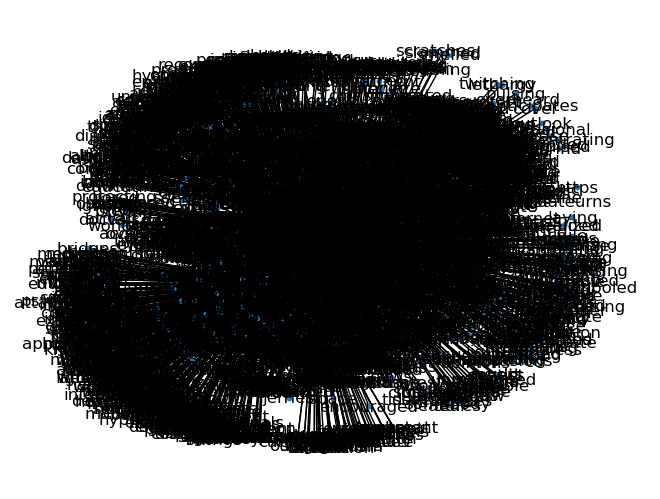

In [56]:

import networkx as nx
import matplotlib.pyplot as plt


graph_to_visualize = stellar_graphs[0]
print(graph_to_visualize.info())


nx_graph = graph_to_visualize.to_networkx()

# pos = nx.spring_layout(nx_graph)  
# nx.draw(nx_graph, pos, with_labels=True, node_size=10)
# plt.show()


In [53]:
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from sklearn.cluster import SpectralClustering
import networkx as nx
from sklearn.cluster import KMeans



segmented_subgraphs = []
graph_relationship = {}

for i, graph in enumerate(stellar_graphs):
    print("Segmenting Graph:", i + 1)

    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=10, length=80, p=0.5, q=2.0)

    node_mapping = {node: idx for idx, node in enumerate(graph.nodes())}
    walks_numeric = [[node_mapping[node] for node in walk] for walk in walks]

    clustering = SpectralClustering(
        n_clusters=100, assign_labels="discretize", random_state=42
    )
    node_labels = clustering.fit_predict(walks_numeric)

    # clustering = KMeans(n_clusters=100, random_state=42)
    # node_labels = clustering.fit_predict(walks_numeric)

    subgraphs = []
    for label in set(node_labels):
        nodes_in_cluster = [
            node
            for node, cluster_label in zip(graph.nodes(), node_labels)
            if cluster_label == label
        ]
        subgraph = graph.subgraph(nodes_in_cluster)

        if len(subgraph.nodes()) > 0:
            subgraphs.append(subgraph)

    segmented_subgraphs.extend(subgraphs)

    graph_relationship[graph] = {"Subgraphs": subgraphs, "Label": labels[i]}


segmented_labels = []
segmented_graphs = []

for original_graph, relationship_info in graph_relationship.items():
    original_label = relationship_info["Label"]
    subgraphs = relationship_info["Subgraphs"]

    for subgraph in subgraphs:
        segmented_labels.append(original_label)
        segmented_graphs.append(subgraph)

segmented_graph_df = pd.DataFrame(
    {"Graph": segmented_graphs, "Label": segmented_labels}
)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from stellargraph import StellarGraph


for i, sg in enumerate(segmented_graphs[:10]):
   
   
    nx_graph = sg.to_networkx()
 
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=8, edge_color='gray', linewidths=0.5)
    plt.title(f'Graph {i + 1}')  # Set a title for each subplot
    plt.show()

# GCN Architecture

![alt](./misc/gcn_arch.PNG)

Generator feeds data to the NN.

- 2 convolutional layers (64-dimensional output features map in each) 
- 2 fully connected layers (producing 32-and 2-dimensional output features, respectively) to predict the mental health or lack off class probabilities. 
- 1 head of graph attention was used in every convolutional layer to implement the filters together with mean-pooling for dimensionality reduction.
- We used Scaled Exponential Linear Unit (SELU) as non-linearity throughout the entire network.
- Hinge loss was employed to train the neural network (we preferred hinge loss to the more commonly
- used mean cross entropy as it outperformed the latter in early experiments). No regularization was
used with our model

In [ ]:
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_hinge
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import numpy as np

generator = PaddedGraphGenerator(graphs=segmented_subgraphs)

label_encoder = LabelEncoder()
segmented_graph_df["Label_encoded"] = label_encoder.fit_transform(
    segmented_graph_df["Label"]
)

# Convert the numeric labels to one-hot encoded vectors
num_classes = len(segmented_graph_df["Label"].unique())
target_labels = to_categorical(
    segmented_graph_df["Label_encoded"], num_classes=num_classes
)


def create_graph_classification_model(generator, target_labels):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["selu", "selu"],
        generator=generator,
        dropout=0.5,
        pooling=None,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="selu")(x_out)
    predictions = Dense(units=num_classes, activation="softmax")(predictions)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(
        optimizer=Adam(0.005),
        loss=categorical_hinge,  # Use categorical hinge loss
        metrics=[categorical_accuracy],
    )

    return model


epochs = 25  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross-validation
n_repeats = 2  # the number of repeats for repeated k-fold cross-validation
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)


def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=0,
        callbacks=[es],
    )
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("categorical_accuracy")]

    return history, test_acc


def get_generators(train_index, test_index, target_labels, batch_size):
    train_targets = target_labels[train_index]
    test_targets = target_labels[test_index]
    train_gen = generator.flow(
        train_index,
        targets=train_targets,
        batch_size=batch_size,
    )
    test_gen = generator.flow(test_index, targets=test_targets, batch_size=batch_size)

    return train_gen, test_gen


test_accs = []

stratified_kfold = StratifiedKFold(n_splits=folds, shuffle=True)

for i, (train_index, test_index) in enumerate(
    stratified_kfold.split(
        segmented_graph_df,
        segmented_graph_df["Label_encoded"],  # Use the encoded labels for splitting
    )
):
    print(f"Training and evaluating on fold {i+1} out of {folds}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, target_labels, batch_size=30
    )

    model = create_graph_classification_model(generator, target_labels)
    assert model is not None

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

    model.save(f"model100k_fold_{i+1}.keras")

print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3f}% and std: {np.std(test_accs)*100:.2f}%"
)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(test_accs * 100)
plt.xlabel("Accuracy")
plt.ylabel("Count")